In [5]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

import pymc3 as pm
import GPy
import arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import pickle

import warnings
warnings.filterwarnings('ignore')

In [792]:
with open('data0904.pickle', 'rb') as pp:
    data = pickle.load(pp)

In [299]:
mapping = {'alum':'Алюминий (тонна/доллар США)',
            'bovespa':'Индекс Bovespa',
          'brent': 'Нефть марки Brent (баррель/доллар США)',
           'bse_sensex': 'Индекс BSE SENSEX',
           'btc_usd': 'Bitcoin/Доллар США',
           'eth_usd': 'Ethereum/Доллар США',
           'eurgbr':'Евро/Британский фунт стерлинга',
           'eurrub': 'Евро/Российский рубль',
           'eurusd': 'Евро/Доллар США',
           'gold': 'Золото (унция/доллар США)',
           'imoex':'Индекс Московской Биржи',
           'lukoil':'Акции Лукойл',
           'megafon':'Акции Мегафон',
           'mts':'Акции МТС',
           'n225': 'Индекс Nikkei 225',
           'nasdaq': 'Индекс NASDAQ Composite',
           'nickel': 'Никель (тонна/доллар США)',
           'nlmk': 'Акции НЛМК',
           'nornikel': 'Акции Норильский Никель',
           'sevstal':'Акции Северсталь',
#            'plat': 'Платина',
           'rtsi':'Индекс PTC',
           'shanghai': 'Индекс Shanghai Composite',
           'silver': 'Серебро (унция/доллар США)',
           'usdrub': 'Доллар США/Российский рубль',
           'wheat': 'Пшеница (5000 бушелей/доллар США)',
#            'yandex': 'Акции Yandex'
          }

currencies = ['btc_usd', 'eth_usd', 'eurgbr', 'eurrub', 'eurusd','usdrub']
indicies = ['bovespa', 'bse_sensex', 'imoex', 'n225', 'nasdaq', 'rtsi']
stocks = ['lukoil','megafon','mts', 'nlmk','nornikel','sevstal']
commodities = ['alum', 'brent','gold','nickel', 'silver', 'wheat']

In [701]:
ts_test = data['btc_usd']['return_abs']
ts_g = data['btc_usd']['return']
ts_g = ts_g.reset_index(drop=True)

In [335]:
def MSE2(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return sum(((y_true**2) - (y_eval**2))**2) / n

def MAE2(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return np.sum(np.abs((y_true**2) - (y_eval**2))) / n

def MdRAE(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    y_true = pd.Series(y_true)
    y_eval = pd.Series(y_eval)
    temp =  ((y_true - y_eval)/ (y_true - y_true.shift()))
    temp = temp.dropna()
    return np.median(np.abs(temp))

def sMAPE(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return np.sum((np.abs(y_true - y_eval)/ (y_true + y_eval))*200) / n
    
    

In [669]:
def fixed_window_naive(ts, window_size=252):
    from datetime import datetime
    dt1 = datetime.now()
    ts_forecasts = {}
    ts_forecasts['naive'] = []
    
    first = 0
    last = window_size
    
    ts = ts.reset_index(drop=True)
    ts = np.array(ts)
    
    for t in range(ts.shape[0] - window_size):
        naive_forecast = ts[window_size+t-1]
        ts_forecasts['naive'].append(naive_forecast)
    
    fcst_df = pd.DataFrame(ts_forecasts)
    length = fcst_df.shape[0]
    
    fcst_df.index = range(251, length+251)
    
    dt2 = datetime.now() - dt1
    print('"Наивная" модель. Выполнено за {}'.format(dt2))
    
    return fcst_df
    

In [628]:
def fixed_window_garch(ts, window_size=252, model_params=('Garch',1,0,1, 2.0, 'Normal')):
    from datetime import datetime
    dt1 = datetime.now()

    ts_forecasts = {}
    
    first = 0
    last = window_size - 1
    
    ts = ts.reset_index(drop=True)
    ts = np.array(ts)
    
    model_to_fit = arch.arch_model(ts, 
                              vol=model_params[0],
                              p=model_params[1], 
                              o=model_params[2], 
                              q=model_params[3],
                              power=model_params[4],
                            dist=model_params[5])
    for t in range(ts.shape[0] - window_size):
        garch_results = model_to_fit.fit(first_obs=first+t, last_obs=last+t, update_freq=0, disp='off')
        temp_res = garch_results.forecast(horizon=1).variance
        temp_forecast = temp_res.iloc[last+t]
        ts_forecasts[temp_forecast.name] = np.sqrt(temp_forecast)
        if t%500 == 0:
            print('Модель {}: посчитана {} точка'.format(model_to_fit.volatility.name, t + 1))
    fcst_var = pd.DataFrame(ts_forecasts).T
    dt2 = datetime.now() - dt1
    print('Выполнено за {}'.format(dt2))
    return fcst_var

In [793]:
def fixed_window_GP(ts, kernel, window_size = 252):
    from datetime import datetime
    dt1 = datetime.now()
    ts_forecasts = {}
    ts_forecasts['GP'] = []
    
    first = 0
    last = window_size
    
    ts = ts.reset_index(drop=True)
    ts = np.array(ts)
    
    ts = np.log(ts + 1)
    
    for t in range(ts.shape[0] - window_size):
        X = np.arange(t, window_size+t).reshape(-1,1)
        y = ts[t:window_size+t].reshape(-1,1)
        GP_model = GPy.models.GPRegression(X,y, kernel)
        GP_model.optimize()
        fcst, var = GP_model.predict(np.array([[window_size+t]]))
        ts_forecasts['GP'].append(np.exp(fcst[0][0]) - 1)
        if t%500 == 0:
            print('Модель GP ({}): посчитана {} точка'.format(GP_model.kern.name, t + 1))
            
    fcst_df = pd.DataFrame(ts_forecasts)
    length = fcst_df.shape[0]
    
    fcst_df.index = range(251, length+251)
    
    dt2 = datetime.now() - dt1
    print('Выполнено за {}'.format(dt2))
    return fcst_df
    
    

In [798]:
btc_fcst = fixed_window_GP(data['btc_usd']['return_abs'], kernel=GPy.kern.RBF(1))

Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Выполнено за 0:06:39.900607


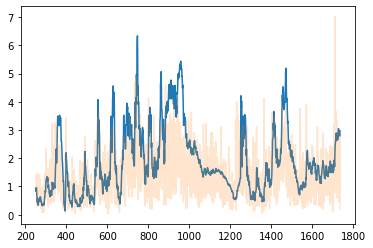

In [799]:
plt.plot(btc_fcst)
plt.plot(np.sqrt(data['btc_usd']['return_abs'].reset_index(drop=True)[252:]), alpha=0.2)

In [689]:
test_fcst_g = fixed_window_garch(ts_g)

Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Выполнено за 0:01:00.114296


In [704]:
test_fcst_naive = fixed_window_naive(ts_test)


"Наивная" модель. Выполнено за 0:00:00.002034


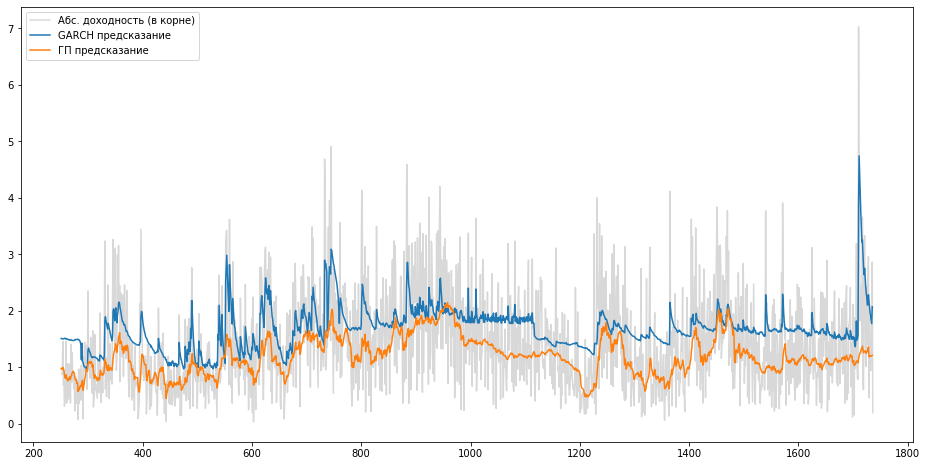

In [707]:
plt.figure(figsize=(16,8))
plt.plot(np.sqrt(ts_test.reset_index(drop=True)[252:]), alpha=0.3, color='grey', label='Абс. доходность (в корне)')
plt.plot(np.sqrt(test_fcst_g), label='GARCH предсказание')
plt.plot(np.sqrt(test_fcst['GP']), label='ГП предсказание')
plt.legend()

In [708]:
garch_param_dict = {
                    'GARCH': ('Garch',1,0,1, 2.0, 'Normal'),
                    'GJR-GARCH':('Garch',1,1,1, 2.0, 'Normal'),
                    'TGARCH':('Garch',1,1,1, 1.0, 'Normal')
                    
                   }

GP_kernel_dict = {
                     'GP (RBF)': GPy.kern.RBF(1),  
                    'GP (Matern52)': GPy.kern.Matern52(1)
                    
}

In [800]:
results_stocks={}
for stock_name in stocks:
    results_stocks[stock_name] = {}
    ts = data[stock_name]['return']
    ts = ts.reset_index(drop=True)
    
    ts_for_GP = data[stock_name]['return_abs']
   
    print('Работа с активом {}'.format(mapping[stock_name]))
    print('-----------------------------------')
    for garch_param in garch_param_dict:
        results_stocks[stock_name][garch_param] = fixed_window_garch(ts, model_params=garch_param_dict[garch_param])
    for GP_kernel in GP_kernel_dict:
        results_stocks[stock_name][GP_kernel] = fixed_window_GP(ts_for_GP, kernel=GP_kernel_dict[GP_kernel])
    results_stocks[stock_name]['naive'] = fixed_window_naive(ts_for_GP)
        
        

Работа с активом Акции Лукойл
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Модель GARCH: посчитана 4501 точка
Выполнено за 0:02:35.060187
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:02:51.630595
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчита

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:03:07.226436
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Модель GP (rbf): посчитана 4501 точка
Выполнено за 0:14:20.195391
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Модель GP (Mat52): посчитана 4001 точка
Модель GP (Mat52): посчитана 4501 точка
Выполнено за 0:15:54.937703
"Наивная" модель. Выполнено за 0:00:00.006015
Работа с активом Акции Мегафон
--------------------------

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univar

Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Выполнено за 0:01:53.935339
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 3501 точка
Выполнено за 0:02:16.126643
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 1501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Выполнено за 0:02:45.787286
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Выполнено за 0:11:54.264192
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Выполнено за 0:13:33.469623
"Наивная" модель. Выполнено за 0:00:00.005985
Работа с активом Акции НЛМК
-----------------------------------
Модель GARCH: посчитана 1 

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Выполнено за 0:01:58.389456
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Выполнено за 0:02:05.588914
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Выполнено за 0:09:04.173747
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): пос

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 4001 точка
Выполнено за 0:02:03.985040
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 4001 точка
Выполнено за 0:02:29.447482
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Выполнено за 0:02:40.559966
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Выполнено за 0:12:05.873909
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Мод

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Выполнено за 0:01:42.364258
Модель GJR-GARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Выполнено за 0:01:59.972198
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Выполнено за 0:02:05.178907
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Выполнено за 0:09:36.493165
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): пос

In [ ]:
results_indicies={}
for index in indicies:
    results_indicies[index] = {}
    ts = data[index]['return']
    ts = ts.reset_index(drop=True)
    
    ts_for_GP = data[index]['return_abs']
   
    print('Работа с активом {}'.format(mapping[index]))
    print('-----------------------------------')
    for garch_param in garch_param_dict:
        results_indicies[index][garch_param] = fixed_window_garch(ts, model_params=garch_param_dict[garch_param])
    for GP_kernel in GP_kernel_dict:
        results_indicies[index][GP_kernel] = fixed_window_GP(ts_for_GP, kernel=GP_kernel_dict[GP_kernel])
    results_indicies[index]['naive'] = fixed_window_naive(ts_for_GP)
        

Работа с активом Индекс Bovespa
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Выполнено за 0:02:11.748558
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Выполнено за 0:02:30.812715
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Выполнено за 0:02:47.176320
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Выполнено за 0:12:48.066151
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Модель GP (Mat52): посчитана 4001 точка
Выполнено за 0:13:17.438858
"Наивная" модель. Выполнено за 0:00:00.004951
Работа с активом Индекс BSE SENSEX
------------------

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Выполнено за 0:01:29.117044
Модель GJR-GARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Выполнено за 0:01:37.950273
Модель TARCH/ZARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Выполнено за 0:01:47.082184
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Выполнено за 0:09:15.433771
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Выполнено за 0:10:00.386658
"Наивная" модель. Выполнено за 0:00:00.004986
Работа с активом Индекс Московской Биржи
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univar

Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:03:10.855391
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:03:14.619295
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Модель GP (rbf): посчитана 4501 точка
Выполнено за 0:14:28.293022
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Модель GP (Mat52): посчитана 4001 точка
Модель 

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Модель GARCH: посчитана 4501 точка
Выполнено за 0:02:31.422673
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univar

Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:02:50.919346
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:02:56.187917
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Модель GP (rbf): посчитана 4501 точка
Выполнено за 0:14:06.198207
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитана 1001 точка
Модель GP (Mat52): посчитана 1501 точка
Модель GP (Mat52): посчитана 2001 точка
Модель GP (Mat52): посчитана 2501 точка
Модель GP (Mat52): посчитана 3001 точка
Модель GP (Mat52): посчитана 3501 точка
Модель GP (Mat52): посчитана 4001 точка
Модель GP (Mat52): посчитана 4501 точка
Выполнен

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Модель GARCH: посчитана 4501 точка
Выполнено за 0:02:17.116783
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:02:49.460265
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Модель TARCH/ZARCH

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 4501 точка
Выполнено за 0:03:19.253995
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:02:39.945978
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:02:47.683006
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Модель GP (rbf): посчитана 4501 точка
Выполнено за 0:13:50.371075
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): 

In [ ]:
with open('results_indicies1604.pickle', 'wb') as rs:
    pickle.dump(results_stocks, rs)

In [801]:
# with open('results_stocks1504.pickle', 'wb') as rs:
#     pickle.dump(results_stocks, rs)

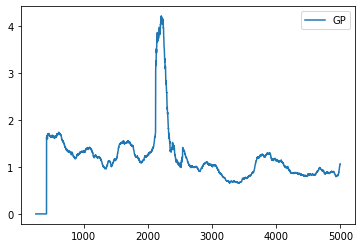

In [844]:
results_stocks['lukoil']['GP (Matern52)'].plot()

In [866]:
results_stocks['lukoil']['GP (Matern52)'] = results_stocks['lukoil']['GP (Matern52)'][168:]

In [867]:
results_stocks['lukoil']['GP (RBF)'] = results_stocks['lukoil']['GP (RBF)'][169:]

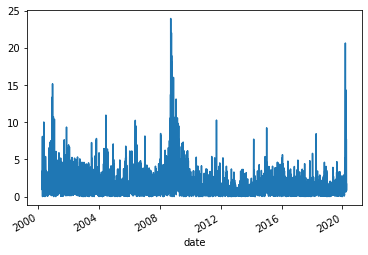

In [724]:
np.exp(np.log(data['lukoil']['return_abs'])).plot()

In [591]:
results_all={}
for asset_group in [stocks, indicies, currencies, commodities]:
    for asset_name in asset_group:

        results_all[asset_name] = {}
        ts = data[asset_name]['return']
        ts = ts.reset_index(drop=True)
        
        ts_for_GP = data[asset_name]['return_abs']

        print('Работа с активом {}'.format(mapping[asset_name]))
        print('-----------------------------------')
        for garch_param in garch_param_dict:
            results_all[asset_name][garch_param] = fixed_window_garch(ts, model_params=garch_param_dict[garch_param])
        for GP_kernel in GP_kernel_dict:
            results_all[asset_name][GP_kernel] = fixed_window_GP(ts_for_GP, kernel=GP_kernel_dict[GP_kernel])
        
        

Работа с активом Акции Лукойл
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Модель GARCH: посчитана 4501 точка
Выполнено за 0:02:26.929839
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:02:40.724241
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчита

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:02:54.804535
Модель GP (rbf): посчитана 1 точка
Модель GP (rbf): посчитана 501 точка
Модель GP (rbf): посчитана 1001 точка
Модель GP (rbf): посчитана 1501 точка
Модель GP (rbf): посчитана 2001 точка
Модель GP (rbf): посчитана 2501 точка
Модель GP (rbf): посчитана 3001 точка
Модель GP (rbf): посчитана 3501 точка
Модель GP (rbf): посчитана 4001 точка
Модель GP (rbf): посчитана 4501 точка
Выполнено за 0:13:09.127430
Модель GP (Mat32): посчитана 1 точка
Модель GP (Mat32): посчитана 501 точка
Модель GP (Mat32): посчитана 1001 точка
Модель GP (Mat32): посчитана 1501 точка
Модель GP (Mat32): посчитана 2001 точка
Модель GP (Mat32): посчитана 2501 точка
Модель GP (Mat32): посчитана 3001 точка
Модель GP (Mat32): посчитана 3501 точка
Модель GP (Mat32): посчитана 4001 точка
Модель GP (Mat32): посчитана 4501 точка
Выполнено за 0:13:52.328877
Модель GP (Mat52): посчитана 1 точка
Модель GP (Mat52): посчитана 501 точка
Модель GP (Mat52): посчитан

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univar

Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка


KeyboardInterrupt: 

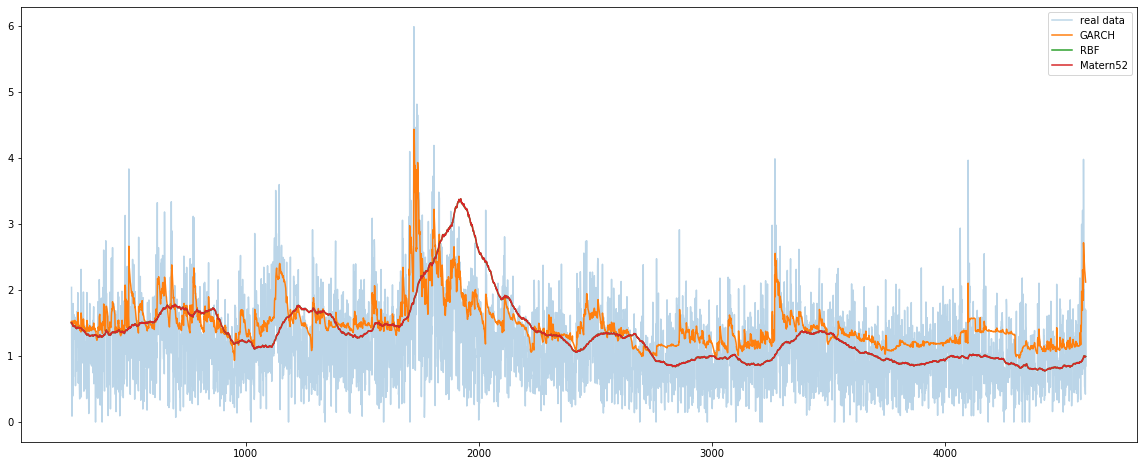

In [845]:
plt.figure(figsize=(20,8))
plt.plot(np.sqrt(data['nornikel']['return_abs'].reset_index(drop=True)[252:]), label='real data', alpha=0.3)
plt.plot(np.sqrt(results_stocks['nornikel']['GARCH']), label='GARCH')
plt.plot(results_stocks['nornikel']['GP (RBF)'], label='RBF')
plt.plot(results_stocks['nornikel']['GP (Matern52)'], label = 'Matern52')
plt.legend()

In [651]:
print(mean_squared_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GJR-GARCH'])))
print(mean_squared_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GP (RBF)'])))
print(mean_squared_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GP (Matern52)'])))

print(mean_absolute_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GJR-GARCH'])))
print(mean_absolute_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GP (RBF)'])))
print(mean_absolute_error(data['megafon']['hl'][252:], np.sqrt(results_all['megafon']['GP (Matern52)'])))

# print(sMAPE(data['lukoil']['return_abs'][252:], np.sqrt(results_all['lukoil']['GARCH'])))
# print(sMAPE(data['lukoil']['return_abs'][252:], np.sqrt(results_all['lukoil']['GP (RBF)'])))
# print(sMAPE(data['lukoil']['return_abs'][252:], np.sqrt(results_all['lukoil']['GP (Matern52)'])))

4.186184185006591
1.2996508446543695
1.2998356880455681
1.7794040093986734
1.1339069140385316
1.1339936376199578


In [334]:
# with open('results_stocks1104.pickle', 'wb') as rs:
#     pickle.dump(results_stocks, rs)

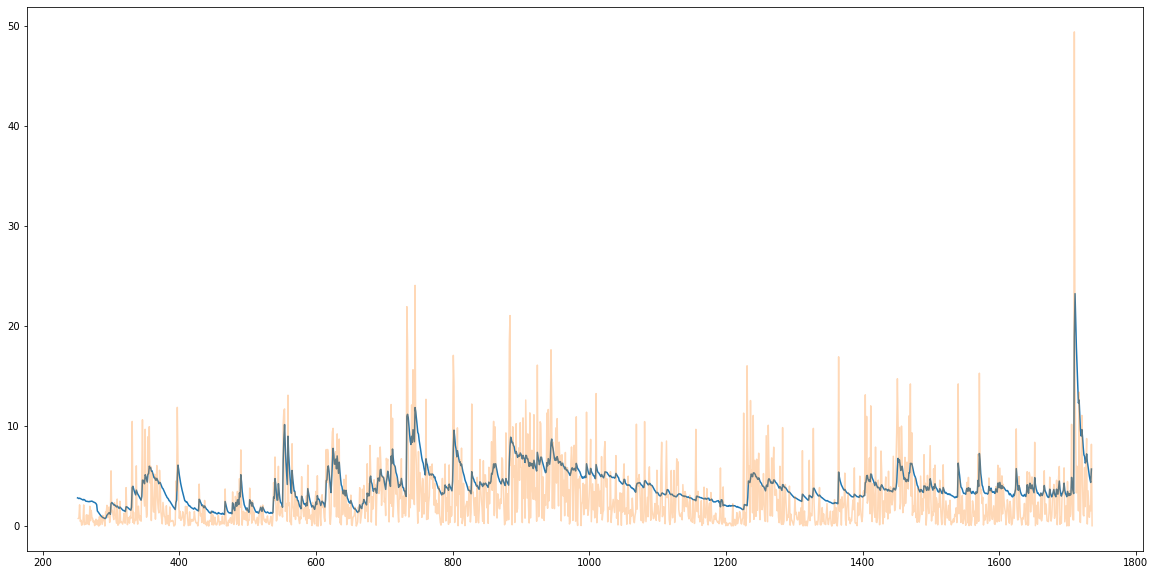

In [584]:
plt.figure(figsize=(20,10))
plt.plot(np.sqrt(ff))
plt.plot(ts_eval[252:], alpha=0.3)

In [882]:
def model_quality(data_true, data_eval, asset_group=stocks, window_size=252, vol_proxy='return_abs'):

    ql=[]
    ql_dict = {}
    for asset_name in data_eval:
        ql_dict[asset_name] = {}
        for model_name in data_eval[asset_name]:
            if asset_name == 'lukoil' and model_name =='GP (RBF)':

                y_true = data_true[asset_name][vol_proxy][window_size+169:]
                y_eval = data_eval[asset_name][model_name]
            elif  asset_name == 'lukoil' and model_name == 'GP (Matern52)':
                y_true = data_true[asset_name][vol_proxy][window_size+168:]
                y_eval = data_eval[asset_name][model_name]
            else:
                y_true = data_true[asset_name][vol_proxy][window_size:]
                y_eval = data_eval[asset_name][model_name]
                

            mse1 = mean_squared_error(y_true, y_eval)
            mae1 = mean_absolute_error(y_true, y_eval)
            mdrae = MdRAE(y_true, y_eval)
            smape =sMAPE(y_true, y_eval)
            
            ql_dict[asset_name][model_name] = [mse1,
                       mae1,
                       mdrae,smape]
            ql.append([mse1,
                       mae1,
                       mdrae,smape])
            
    ql = np.array(ql).reshape(6,-1)
            
    multi_index = pd.MultiIndex.from_product([['GARCH','GJR-GARCH','TGARCH', 'GP (RBF)', 'GP (Matern52)', '"Наивная" модель'],
                                              ['MSE1','MAE1', 'MdRAE', 'sMAPE']], 
                                              names=['Модель','Метрика качества']) 
    
    return pd.DataFrame(ql, index=asset_group, columns=multi_index)
    
    
    

In [885]:
df = model_quality(data,results_stocks)
# df.T.to_excel('stocks_dfT1504.xls')

In [585]:
mean_squared_error(ts_eval[252:], np.sqrt(ff)), mean_squared_error(ts_eval[252:], ff)

(11.988831218656076, 1039.0429648643708)

In [586]:
sMAPE(ts_eval[252:], np.sqrt(ff))

89.30065111312251

In [134]:
gjr = arch.arch_model(ts, vol='Garch', p=1, o=0, q=1, power=2.0)
# garch = arch.arch_model(ts['return'], vol='Garch', p=1, o=0, q=1, power=1.0)

In [124]:
# gjr_result = gjr.fit()
garch_result = garch.fit(update_freq=0, disp='off', show_warning=False)

In [143]:
gjr.volatility.name

'GARCH'

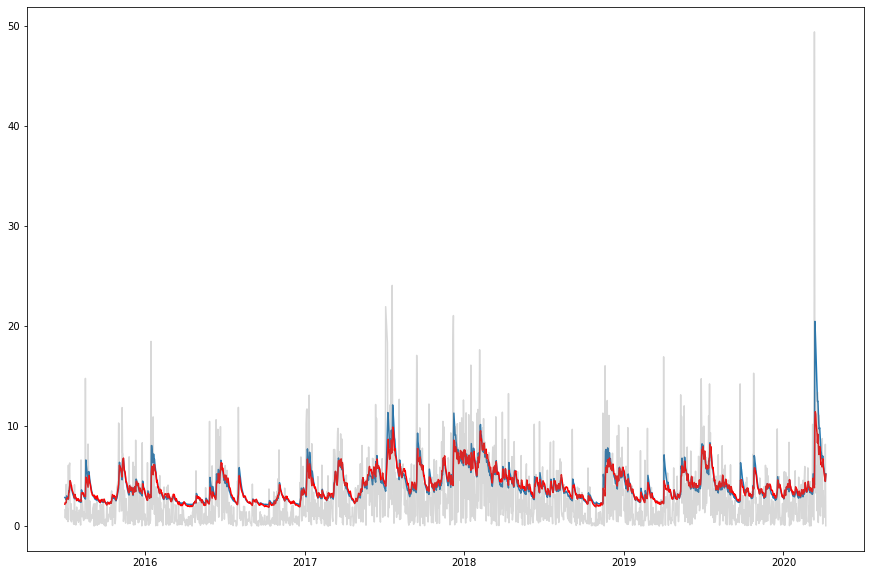

In [45]:
plt.figure(figsize=(15,10))
plt.plot(gjr_result.conditional_volatility)
plt.plot(garch_result.conditional_volatility, c='red')
plt.plot(ts['return_abs'], color='grey', alpha=0.3)